In [51]:
!git clone https://github.com/Damowerko/ese2000-dynamical-systems.git
import sys
sys.path.append('./ese2000-dynamical-systems/')

fatal: destination path 'ese2000-dynamical-systems' already exists and is not an empty directory.


In [52]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
from tqdm.notebook import trange

from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track
from ese2000_dynamical.simulator import Simulator, dynamics_ca
from torch import nn

data_path = Path("./ese2000-dynamical-systems/data")

# device for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(10, 200, 4)


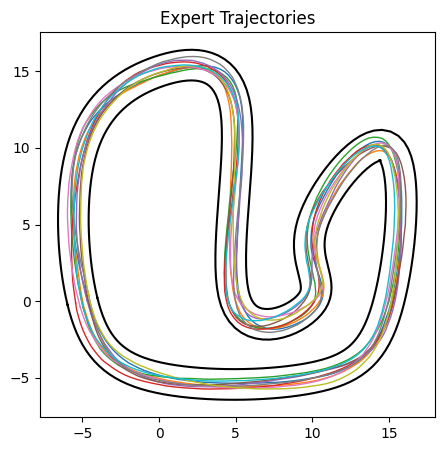

In [53]:
x_expert = np.load(data_path / "states.npy")
u_expert = np.load(data_path / "inputs.npy")
track = load_track(data_path / "track.npz")

plt.figure(figsize=(10, 5))
plt.gca().set_aspect("equal")
track.plot(plt.gca())
plt.title("Expert Trajectories")
print(x_expert.shape)
for x_ in x_expert:
    plt.plot(x_[:, 0], x_[:, 1], "-", linewidth=1.0)

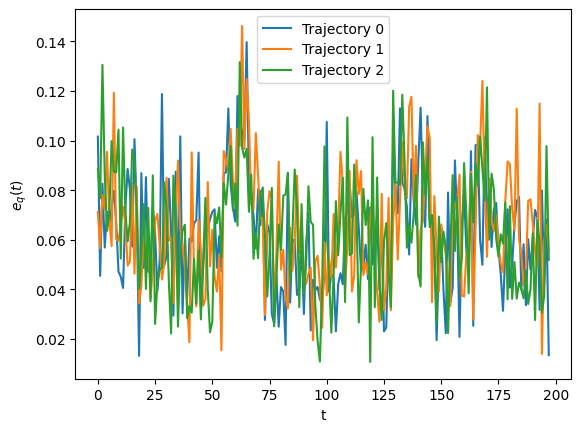

In [54]:
trajectories = x_expert.shape[0]
T = Config.duration
Ts = Config.time_step
num_steps = int(T/Ts)
for trajectory_idx in range(trajectories-7):
  x_trajectory = x_expert[trajectory_idx]
  v = x_trajectory[:, 2:]
  p = x_trajectory[:, :2]
  a = u_expert[trajectory_idx]
  error = []
  for t in range(1, num_steps-1):# we start predicting the for t=1
    # Predict velocity v[t] + a[t]
    hat_v = v[t] + Ts * a[t]
    # predict position
    hat_p = p[t] + Ts * v[t] + (Ts**2/2)*a[t]

    # compute error
    e_t = np.linalg.norm(p[t+1] - hat_p)+ np.linalg.norm(v[t+1] - hat_v)
    error.append(e_t)

  # plot error evolution
  plt.plot(error, label=f"Trajectory {trajectory_idx}")

plt.xlabel("t")
plt.ylabel("$e_q(t)$")
plt.legend()
plt.show()

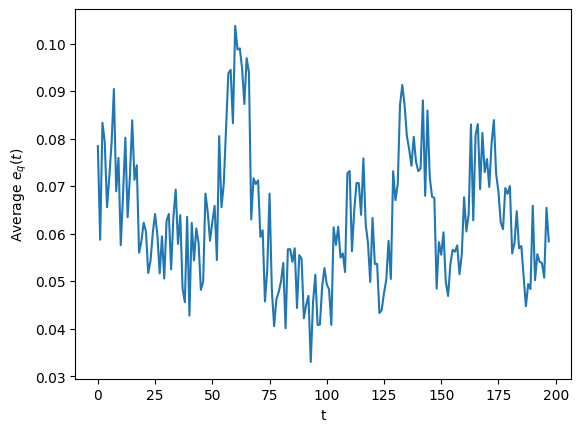

Average error over time is: 0.06329752727784835


In [55]:
num_trajectories = x_expert.shape[0]
avg_error = []
for t in range(1, num_steps-1):# we start predicting the for t=1
  error_t = 0
  for trajectory_idx in range(num_trajectories):
    x_trajectory = x_expert[trajectory_idx]
    v = x_trajectory[:, 2:]
    p = x_trajectory[:, :2]
    a = u_expert[trajectory_idx]
    # Predict velocity v[t] + a[t]
    hat_v = v[t] + Ts * a[t]
    # predict position
    hat_p = p[t] + Ts * v[t] + (Ts**2/2)*a[t]

    # compute error and add it to total error
    error_t += np.linalg.norm(p[t+1] - hat_p)+ np.linalg.norm(v[t+1] - hat_v)

  avg_error.append(error_t/num_trajectories)

# plot error evolution
plt.plot(avg_error)
plt.xlabel("t")
plt.ylabel("Average $e_q(t)$")
plt.show()
avg_error_time = np.mean(avg_error)
print(f"Average error over time is: {avg_error_time }" )

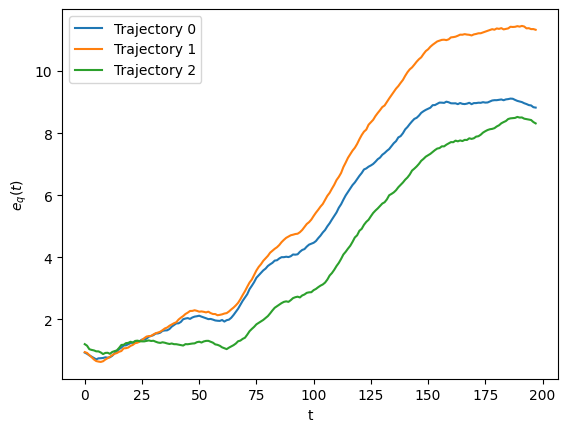

In [56]:
trajectories = x_expert.shape[0]
T = Config.duration
Ts = Config.time_step
num_steps = int(T/Ts)
for trajectory_idx in range(trajectories-7):
  x_trajectory = x_expert[trajectory_idx]
  v = x_trajectory[:, 2:]
  p = x_trajectory[:, :2]
  a = u_expert[trajectory_idx]
  hat_v = v[0]
  hat_p = p[0]
  error = []
  for t in range(1, num_steps-1):# we start predicting the for t=1
    # Predict velocity v[t] + a[t]
    hat_v = hat_v + Ts * a[t]
    # predict position
    hat_p = hat_p + Ts * hat_v + (Ts**2/2)*a[t]

    # compute error
    e_t = np.linalg.norm(p[t+1] - hat_p)+ np.linalg.norm(v[t+1] - hat_v)
    error.append(e_t)

  # plot error evolution
  plt.plot(error, label=f"Trajectory {trajectory_idx}")

plt.xlabel("t")
plt.ylabel("$e_q(t)$")
plt.legend()
plt.show()

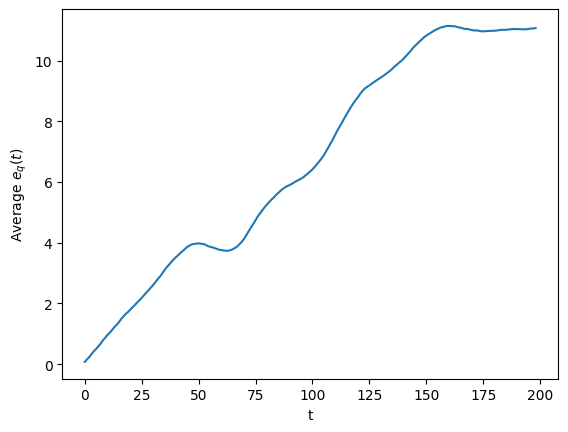

Average error over time is: 6.69229001081394


In [57]:
num_trajectories = x_expert.shape[0]
T = Config.duration
Ts = Config.time_step
num_steps = int(T/Ts)
error = np.empty((num_trajectories, num_steps-1))
for trajectory_idx in range(num_trajectories):
  x_trajectory = x_expert[trajectory_idx]
  v = x_trajectory[:, 2:]
  p = x_trajectory[:, :2]

  a = u_expert[trajectory_idx]
  hat_v = v[0]
  hat_p = p[0]
  for t in range(0, num_steps-1):# we start predicting the for t=1
    # Predict velocity v[t] + a[t]
    hat_v = hat_v + Ts * a[t]
    # predict position
    hat_p = hat_p + Ts * hat_v + (Ts**2/2)*a[t]

    # compute error
    error[trajectory_idx, t] = np.linalg.norm(p[t+1] - hat_p) + np.linalg.norm(v[t+1] - hat_v)

avg_error = np.mean(error, axis=0)


plt.plot(avg_error)
plt.xlabel("t")
plt.ylabel("Average $e_q(t)$")
plt.show()
avg_error_time = np.mean(error)
print(f"Average error over time is: {avg_error_time }" )

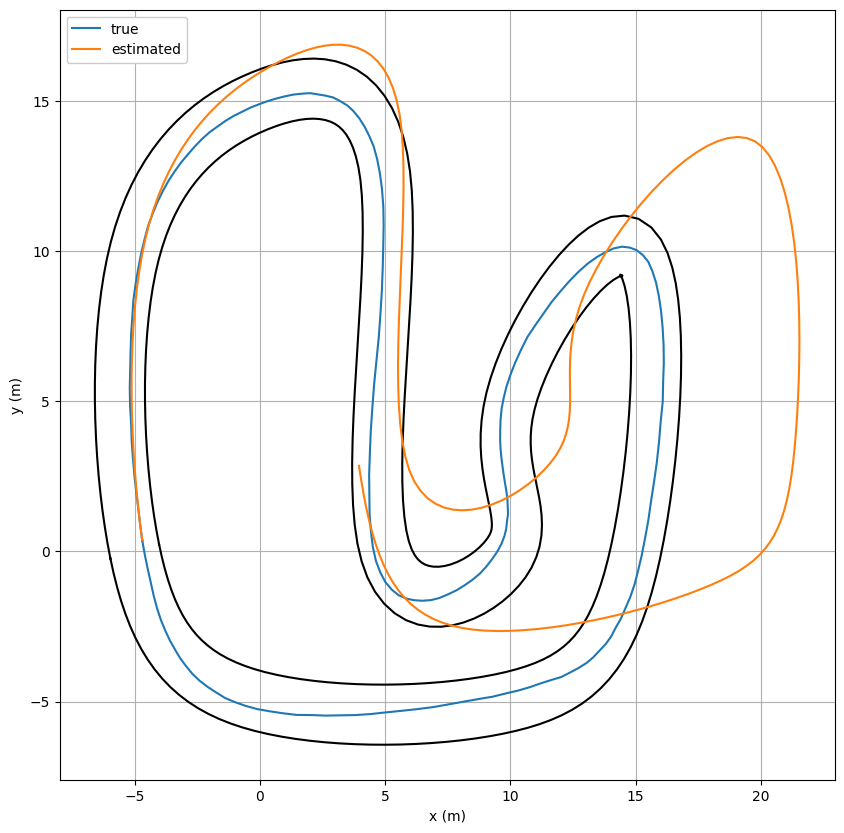

In [58]:
# Predicting system (f) but we are not predicting the decisions.
# The decisions are given to us.

hat_p = np.empty((num_steps, 2))
trajectory_idx = 5
x_trajectory = x_expert[trajectory_idx]
v = x_trajectory[:, 2:]
p = x_trajectory[:, :2]
a = u_expert[trajectory_idx]
# initial values
# use the same starting point as the expert
hat_v = v[0]
hat_p[0] = p[0]
for t in range(0, num_steps-1):# we start predicting the for t=1
  # Predict velocity v[t] + a[t]
  hat_v = hat_v + Ts * a[t]
  # predict position
  hat_p[t+1] = hat_p[t] + Ts * hat_v + (Ts**2/2)*a[t]

plt.figure(figsize=(10, 10))
track.plot()
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
# Plot positions
plt.plot(p[:, 0], p[:, 1], "-", label="true")
# plot predictions
plt.plot(hat_p[:, 0], hat_p[:, 1], "-", label="estimated")
plt.legend(loc="upper left", framealpha=1.0)
plt.show()

In [59]:
# we are given a set of positions and accelerations.
# For every time, except for time 0, we use the observed position and accelartaion
# with some learned model f (the multiplication of A*x + B*u) to predict the
# next position
class LinearModel(nn.Module):
    def __init__(self, A, B):
      super().__init__()
      self.A = nn.parameter.Parameter(A)
      self.B = nn.parameter.Parameter(B)
    def forward(self, x, u):
        return x@self.A+ u@self.B

In [60]:
n_steps = 10000
lr = 5e-4

# convert to tensors
x = torch.from_numpy(x_expert).float()
u = torch.from_numpy(u_expert).float()

# save fith trajectory for validation
x_train = torch.cat((x[:4], x[5:]))
u_train = torch.cat((u[:4], u[5:]))
x_test = x[5]
u_test = u[5]

n_states = 4 # p and v
n_inputs = 2# acc

A_init = torch.zeros(n_states, n_states, device=device, requires_grad=True)
B_init = torch.zeros(n_inputs, n_states, device=device, requires_grad=True)

model = LinearModel(A_init, B_init)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)


for i in range(n_steps):
    optimizer.zero_grad()
    # compute predictions for t+1 = 1..T
    #we dont need to compute predictions for last state
    # and thus use state[:, :-1]
    x_pred = model(x_train[:, :-1], u_train[:, :-1])
    loss = (x_train[:, 1:] - x_pred).pow(2).mean()
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
      print(f"Step: {i} \t Train Loss: {loss.item()}")

Step: 0 	 Train Loss: 57.14374542236328
Step: 1000 	 Train Loss: 0.02006038837134838
Step: 2000 	 Train Loss: 0.0004425234510563314
Step: 3000 	 Train Loss: 0.000254583457717672
Step: 4000 	 Train Loss: 0.00025277776876464486
Step: 5000 	 Train Loss: 0.0002527607139199972
Step: 6000 	 Train Loss: 0.00025276021915487945
Step: 7000 	 Train Loss: 0.0002527602482587099
Step: 8000 	 Train Loss: 0.00025276027736254036
Step: 9000 	 Train Loss: 0.00025276027736254036


In [61]:
x_pred_test = model(x_test[:-1], u_test[:-1])
test_loss = (x_test[1:] - x_pred_test).pow(2).mean()
print(f"Test Loss: {test_loss}")

Test Loss: 0.00024410879996139556


In [62]:
x_pred_test = torch.empty((num_steps, 4))
print(x_test.size())
x_pred_test[0] = x_test[0]
for t in range(num_steps-1):
  x_pred_test[t+1] = model(x_pred_test[t], u_test[t])

x_pred_test = x_pred_test[1:]

torch.Size([200, 4])


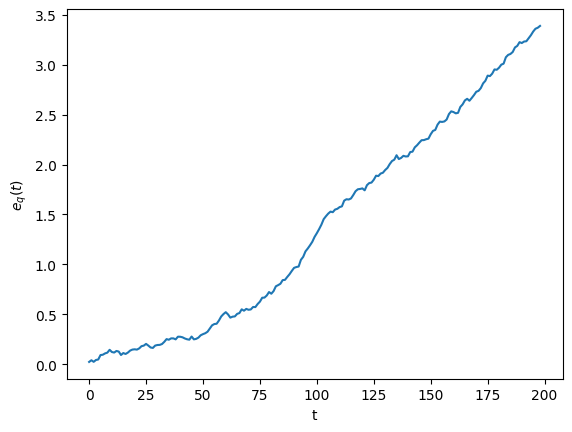

<built-in method size of Tensor object at 0x281ea7680>
Average error over time is: 1.3796671628952026


In [63]:
error = np.empty(num_steps-1)
error = x_test[1:] - x_pred_test
error_p = error[:, :2]
error_v = error[:, :2]
# compute error for each timestep
error = torch.linalg.norm(error_v, axis=1)+torch.linalg.norm(error_v, axis=1)
# plot error evolution
plt.plot(error.detach().numpy())
plt.xlabel("t")
plt.ylabel("$e_q(t)$")
plt.show()
print(error.size)
avg_error_time = torch.mean(error).detach().numpy()
print(f"Average error over time is: {avg_error_time }" )

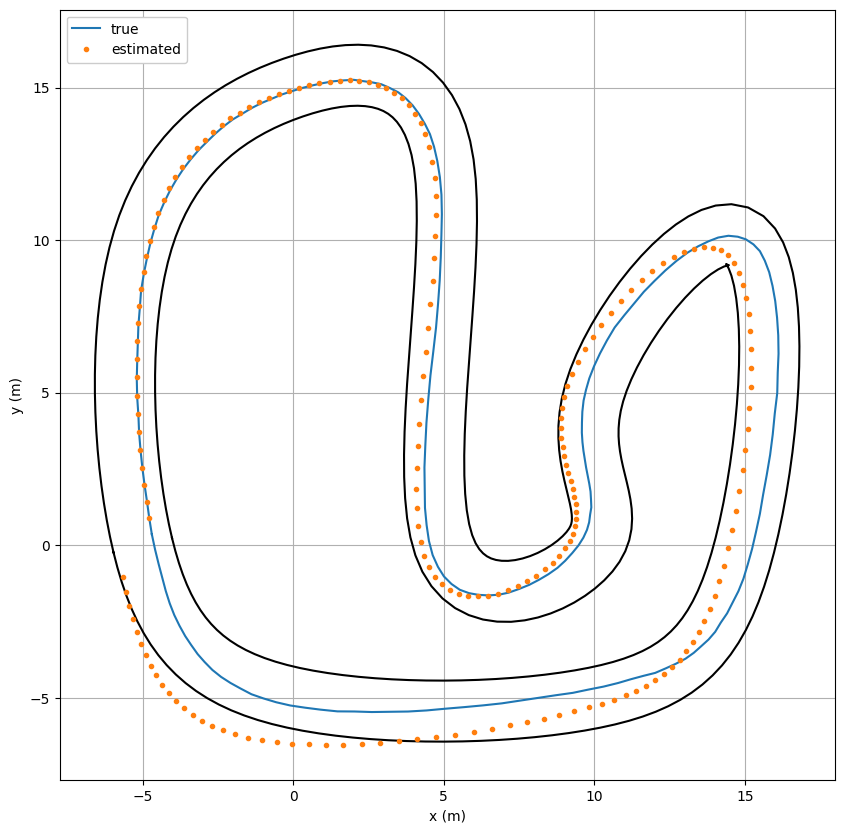

In [64]:
x_test_np = x_test.detach().numpy()
x_pred_test_np = x_pred_test.detach().numpy()
plt.figure(figsize=(10, 10))
track.plot()
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_test[:, 0], x_test[:, 1], "-", label="true")
plt.plot(x_pred_test_np[:, 0], x_pred_test_np[:, 1], ".", label="estimated")
plt.legend(loc="upper left", framealpha=1.0)
plt.show()

In [65]:
import torch

torch.set_float32_matmul_precision("medium")


def rollout(A, B, u, x0):
    """
    Integrate the system dynamics to predict the trajectory.

    Args:
        A: (4, 4) The state transition matrix.
        B: (2, 4) The input matrix.
        u: (T, 2) The control inputs.
        x0: (4,) The initial state.
    """
    x = torch.zeros((len(u) + 1, A.shape[0]), device=A.device)
    x[0] = x0
    for i in range(len(u)):
        x[i + 1] = x[i] @ A + u[i] @ B
    # return the predicted trajectory
    return x[1:]

In [66]:
expert_idx = 5
x_expert = x_expert[expert_idx]

A = model.A.detach()
B = model.B.detach()
x0 = torch.tensor(x_expert[0]).float()
x_ref = torch.tensor(x_expert[1:]).float()
u_naive = torch.zeros(len(x_ref), 2, requires_grad=True).float()
optimizer = torch.optim.Adam([u_naive], lr=1.0)

for i in range(1000):
    optimizer.zero_grad()
    x_pred = rollout(A, B, u_naive, x0)
    # penalize the difference between the predicted and reference trajectory
    loss = (x_pred - x_ref).pow(2).mean()
    # add loss to progress bar
    if i % 100 == 0:
      print(f"Step: {i} \tLoss: {loss.item()}")
    loss.backward()
    optimizer.step()


Step: 0 	Loss: 514.6283569335938
Step: 100 	Loss: 8.27013111114502
Step: 200 	Loss: 3.4032528400421143
Step: 300 	Loss: 1.4440983533859253
Step: 400 	Loss: 0.7261592745780945
Step: 500 	Loss: 0.43223798274993896
Step: 600 	Loss: 0.28022682666778564
Step: 700 	Loss: 0.18678425252437592
Step: 800 	Loss: 0.12498848140239716
Step: 900 	Loss: 0.0833144560456276


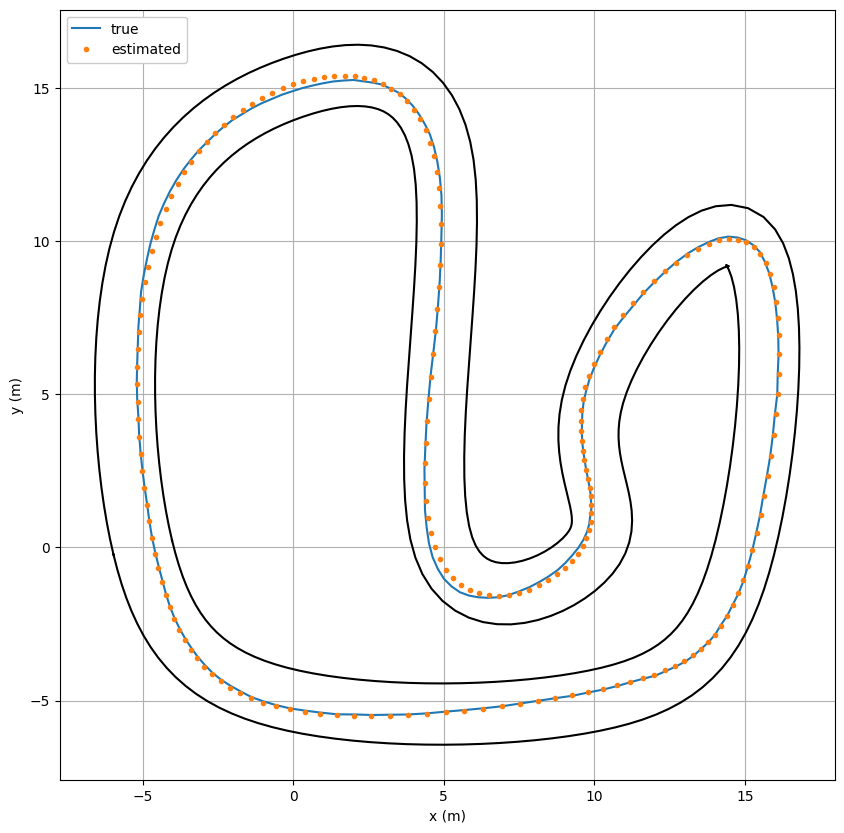

In [67]:
x_test_np = x_expert
x_pred_test_np = x_pred.detach().numpy()
plt.figure(figsize=(10, 10))
track.plot()
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_test[:, 0], x_test[:, 1], "-", label="true")
plt.plot(x_pred_test_np[:, 0], x_pred_test_np[:, 1], ".", label="estimated")
plt.legend(loc="upper left", framealpha=1.0)
plt.show()

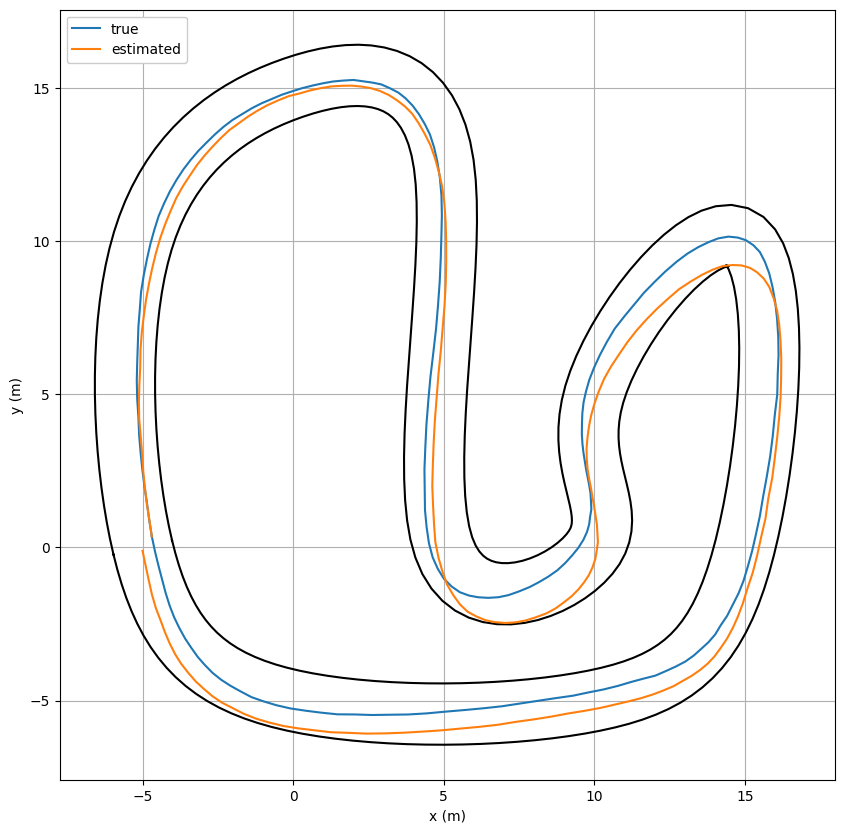

In [68]:
simulator = Simulator()
t = np.arange(0, Config.duration, Config.time_step)
x_estimate = np.zeros_like(x_expert)
# use the starting point as the initial estimate
x_estimate[0] = x_expert[0]
for i in range(len(t) - 1):
    x_estimate[i + 1] = simulator.step(x_estimate[i], u_naive[i].detach().cpu().numpy())

plt.figure(figsize=(10, 10))
track.plot(plt.gca())
plt.grid(True)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(x_expert[:, 0], x_expert[:, 1], "-", label="true")
plt.plot(
    x_estimate[:, 0],
    x_estimate[:, 1],
    "-",
    label="estimated",
)
plt.legend(loc="upper left", framealpha=1.0)
plt.show()

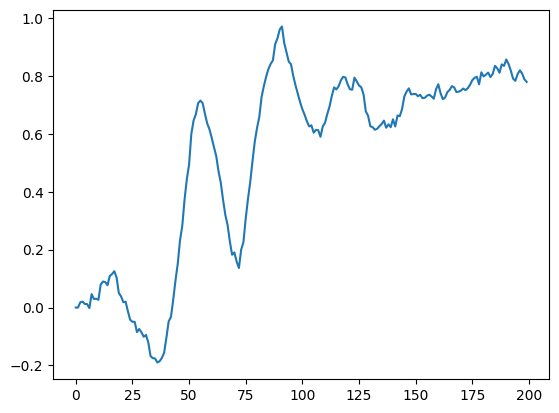

In [74]:
estimate_x = x_estimate[:, 0]
estimate_y = x_estimate[:, 1]
true_x = x_expert[:, 0]
true_y = x_expert[:, 1]
loss = true_x - estimate_x + true_y - estimate_y
plt.plot(loss)
plt.show()

